In [1]:
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
%pwd

import os
import numpy             as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.rcParams['figure.figsize']  = (16,8)

from tensorflow.keras.models import load_model
from osgeo                   import gdal
from PIL                     import Image
from src.io                  import get_image_array
from src.inference           import mask_with_model, mask_simulated
from src.sarsim              import gen_simulated_deformation, gen_sim_noise, gen_simulated_time_series

/home/andrew/repos/AI-Event-Monitoring


In [2]:
def plot_results(wrapped, mask, presence_mask):

    _, [axs_wrapped, axs_mask, axs_presence_mask] = plt.subplots(1, 3)

    axs_wrapped.set_title('Wrapped')
    axs_mask.set_title('Segmentation Mask')
    axs_presence_mask.set_title('Presence Mask')
    
    axs_wrapped.imshow(wrapped, origin='lower', cmap='jet')
    axs_mask.imshow(mask, origin='lower', cmap='jet')
    axs_presence_mask.imshow(presence_mask, origin='lower', cmap='jet')

In [65]:
def mask_simulated(
    mask_model,
    seed:           int,
    tile_size:      int,
    crop_size:      int   = 0,
    verbose:        bool  = False,
    noise_only:     bool  = False,
    gaussian_only:  bool  = False,
    zero_output:    bool  = False,
    event_type:     str   = 'quake',
    tolerance:      float = 0.7
) -> None:

    """
    Predicts the event-mask on a synthetic wrapped interferogram and plots the results.

    Parameters:
    -----------
    model_path : str
        The path to the model that does the masking.
    seed : int
        A seed for the random functions. For the same seed, with all other values the same
        as well, the interferogram generation will have the same results. If left at 0,
        the results will be different every time.
    tile_size : int
        The dimensional size of the simulated interferograms to generate, this must match the
        input shape of the model.
    crop_size : int, Optional
        If the models output shape is different than the input shape, this value needs to be
        equal to the output shape.
    use_sim : bool, Optional
        Use simulated interferograms rather than synthetic interferograms

    Returns:
    --------
    None
    """

    n_interferograms = 32
    
    if crop_size == 0:
        crop_size = tile_size

    if not noise_only:
        phases, mask = gen_simulated_time_series(
            n_interferograms = n_interferograms,
            seed       = seed,
            tile_size  = tile_size,
            noise_only = False
        )
    else:
        phases, mask = gen_simulated_time_series(
            n_interferograms = n_interferograms,
            seed       = seed,
            tile_size  = tile_size,
            noise_only = True,
        )

    input_phases = phases[:, 0, :, :]
    
    print(mask.shape)
    
    wrapped   = input_phases.transpose().swapaxes(0, 1)
    wrapped   = wrapped.reshape((1, *wrapped.shape, 1))
    mask_pred = np.float32(mask_model.predict(wrapped))

    return input_phases, mask, mask_pred

In [66]:
tile_size = 512
crop_size = 512

mask_model_path = 'data/output/models/checkpoints/XTest3DUnet'

mask_model = load_model(mask_model_path)

wrapped, mask, mask_pred = mask_simulated(mask_model, seed=0, tile_size=512)

(512, 512)


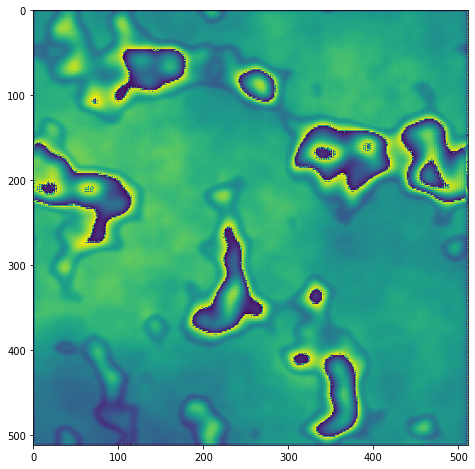

In [67]:
mask_accumulated = np.zeros((512, 512))
for i in range(32):
    mask_accumulated += mask_pred[0, :, :, i, 0]
plt.imshow(np.angle(np.exp(1j * mask_accumulated)))

(1, 512, 512, 32, 1)


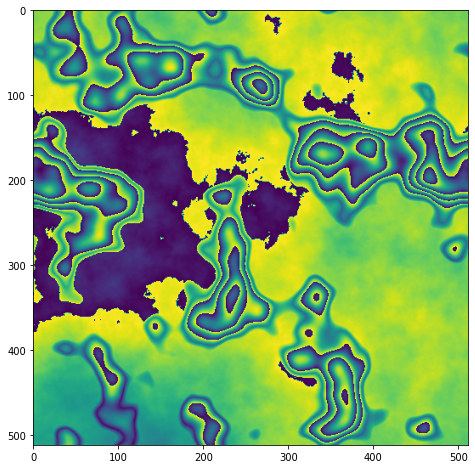

In [68]:
wrapped_copy = wrapped.transpose().swapaxes(0, 1)
wrapped_copy = wrapped_copy.reshape((1, *wrapped_copy.shape, 1))

print(wrapped_copy.shape)

arr = np.zeros((512, 512))
for i in range(32):
    arr += wrapped_copy[0, :, :, i, 0]

plt.imshow(np.angle(np.exp(1j * arr)))

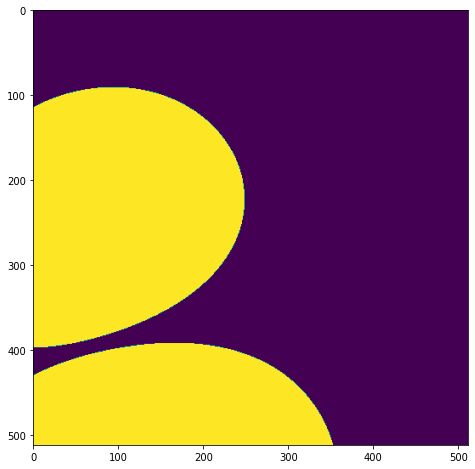

In [69]:
plt.imshow(mask)